In [ ]:
# | hide
%load_ext autoreload
%autoreload 2

# Decision Diagrams - Routing Agents

In [ ]:
from stringdale import Define,V,E
from stringdale.chat import Chat

In [ ]:
def add(a,b):
    return a+b

class Pow():
    def __init__(self,power):
        self.power = power
    def __call__(self,a):
        return a**self.power
    def __str__(self):
        return f'Pow({self.power})'

## Different types of diagrams

The type of diagrams we have seen so far are called flow diagrams.
In Flow diagrams:

* There are no cycles
* All nodes run based on the output

Another Type of Diagrams are Decision Diagrams.
In Decision diagrams:

* You can have cycles
* After Each Node, we need to choose the next node to run based on a condition function.

Flow diagrams are the default type but we can also define them explicitly.

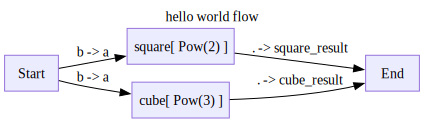

In [ ]:
with Define('hello world flow',type='flow') as D:
    V('square',Pow(2),inputs=['Start(a=b)'],outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

D.draw()

Decision diagrams can be defined in a similar manner

In [ ]:
def is_b_even(obj):
    return obj['b']%2==0

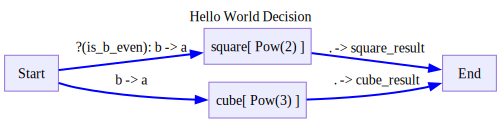

In [ ]:
with Define('Hello World Decision',type='decision') as D:
    V('square',Pow(2),outputs=['End(square_result=.)'])
    V('cube',Pow(3),outputs=['End(cube_result=.)'])
    # we define conditional edges by adding a cond argument to the edge
    E('Start->square(a=b)',cond=is_b_even)
    # each non-end node must have at least one edge with no condition, the default edge
    E('Start->cube(a=b)')
D.draw()


We can also inline conditional edge definition in the node definition by providing a tuple of the form `(edge_string,cond)` to the `inputs` or `outputs` keys.

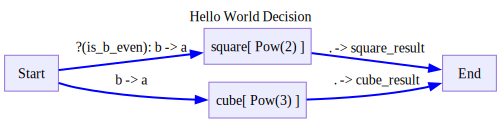

In [ ]:
with Define('Hello World Decision',type='decision') as D:
    V('square',Pow(2),
        inputs=[('Start(a=b)',is_b_even)],
        outputs=['End(square_result=.)'])
        
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])
D.draw()

Unlike in our flow example, here either square or cube is called, but not both.

In [ ]:
d=D()
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output

Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4}

In [ ]:
d=D()
for trace in d.run({'a':1,'b':3}):
    trace.pprint(skip_passthrough=True)
d.output

Node cube:
{'input': {'a': 3}, 'output': 27}


{'cube_result': 27}

## Introduce Diagram State

Often, we would like to use state from previous nodes.
In flow diagrams, we can simply connect them, but in decision diagrams, this can make the diagram not well defined.

To solve this problem, stringdale has support for diagram states.

Here is a basic example of it:

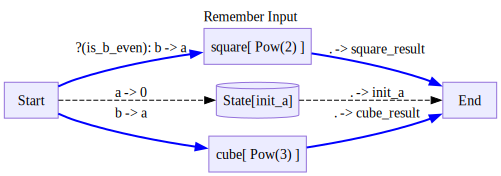

Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4, 'init_a': 1}

In [ ]:
with Define('Remember Input',type='decision') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',is_b_even),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

    # We can write and read from the state using nodes of the from 'State/key'
    # State nodes are special nodes that are not part of the execution, but are used to store information.
    E('Start->State/init_a(0=a)')
    V('End',inputs=['State/init_a(init_a=.)'])
    
D.draw()
d=D()
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output


We can initialize diagram state using the diagram's `state` attribute.

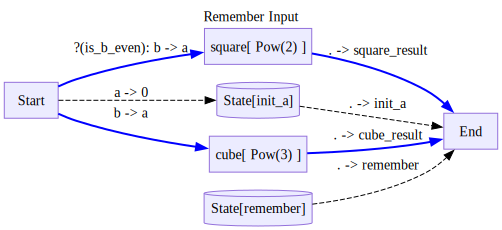

Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4, 'init_a': 1, 'remember': 100}

In [ ]:
with Define('Remember Input',type='decision') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',is_b_even),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

    E('Start->State/init_a(0=a)')
    V('End',inputs=['State/init_a(init_a=.)'])
    V('End',inputs=['State/remember(remember=.)'])

D.draw()
d=D()
d.state.remember = 100
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output


Diagram State is a very powerful feature of stringdale. To learn more about the power of state, see the customizing state section.

## Conditions made easier

Having to write funciton like checking if the key `b` is even can get out of hand pretty fast.

To avoid having to write alot of small condition functions for different object configurations,
stringdale's standard library has a `Condition` class that gives you the power of port mapping in your conditions.

In [ ]:
from stringdale import Condition

In [ ]:
is_even = lambda x: x%2==0
smaller_than_5 = lambda x: x<5

is_b_even = Condition(is_even,mapping='x=b',name='is_b_even')

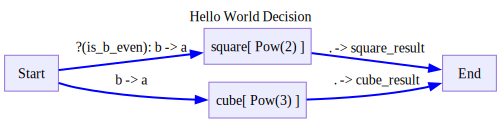

Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4}

In [ ]:
with Define('Hello World Decision',type='decision') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',is_b_even),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])

D.draw()
d=D()
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output

`Condition` has a bunch of other nice utilities, such as the ability to combine conditons via `and` or `or`

In [ ]:
b_smaller_than_5 = Condition(smaller_than_5,mapping='x=b',name='b_smaller_than_5')

even_but_not_too_big = is_b_even & b_smaller_than_5
even_but_not_too_big

(is_b_even & b_smaller_than_5)

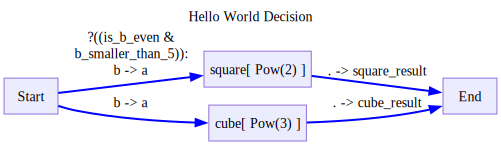

In [ ]:
with Define('Hello World Decision',type='decision') as D:
    V('square',Pow(2),inputs=[
        ('Start(a=b)',even_but_not_too_big),
        ],
        outputs=['End(square_result=.)'])
    V('cube',Pow(3),inputs=['Start(a=b)'],outputs=['End(cube_result=.)'])
D.draw()

In [ ]:
d=D()
for trace in d.run({'a':1,'b':2}):
    trace.pprint(skip_passthrough=True)
d.output

Node square:
{'input': {'a': 2}, 'output': 4}


{'square_result': 4}

In [ ]:
d=D()
for trace in d.run({'a':1,'b':10}):
    trace.pprint(skip_passthrough=True)
d.output

Node cube:
{'input': {'a': 10}, 'output': 1000}


{'cube_result': 1000}

You can find out more about `Condition` and other utilities in the utils section.

## Example - Routing Agents

Here is an example of a LLM that monitors another LLM, prompting it until it returns a satisfactory response.

In [ ]:
rhyming_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following questions using rhyming words.
    """},
    {'role':'user','content':'{{question}}'},
    ],
    )


await rhyming_agent(question='what is the capital of france?')

{'role': 'assistant',
 'content': 'In Paris, the heart beats bright, a city of charm, a glorious sight.',
 'meta': {'input_tokens': 129, 'output_tokens': 24}}

In [ ]:
joke_agent = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following question with a joke.
    """},
    {'role':'user','content':'{{question}}'},
    ])

await joke_agent(question='what is the capital of france?')

{'role': 'assistant',
 'content': 'Why did the French chef get arrested? Because he was caught beating the eggs in Paris!',
 'meta': {'input_tokens': 127, 'output_tokens': 26}}

In [ ]:
yo_mama_chat = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Answer the following question with a joke about the person's mother.
    """},
    {'role':'user','content':'{{question}}'},
    ])

await yo_mama_chat(question='what is the capital of france?')

{'role': 'assistant',
 'content': "Why did your mother go to Paris? Because she heard it was the best place to find a good croissant – and we all know that's her idea of an open-air bakery!",
 'meta': {'input_tokens': 131, 'output_tokens': 43}}

In [ ]:
choice_descriptions = {
    'rhyme':'this agent is good at rhyming',
    'joke': 'this agent is good at telling jokes',
    'yo_mama': 'this agent is specifically good at telling jokes about mothers'
}

In [ ]:
router = Chat(model='gpt-4o-mini',
    messages=[{'role':'system','content':"""
    Choose the best sub-agent to answer the following question from among the following options:
    {% for name,description in choice_descriptions.items() %}
    - {{name}}: {{description}}
    {% endfor %}
    """},
    {'role':'user','content':'{{question}}'},
    ],
    choice_descriptions = choice_descriptions,
    choices=list(choice_descriptions.keys())
    )
    
router

Chat(model='gpt-4o-mini', required_keys={'question'}, seed=42)

In [ ]:
await router(question='tell me a joke about my mother')

{'role': 'assistant',
 'content': 'yo_mama',
 'meta': {'input_tokens': 198, 'output_tokens': 11}}

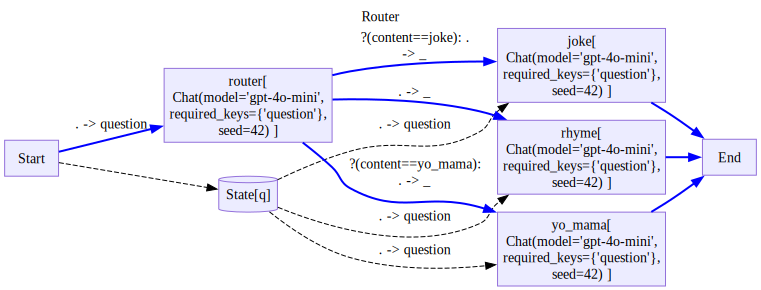

In [ ]:
with Define('Router',type='decision') as Router:
    E('Start->state/q')
    V('router',router,
        inputs=['Start(question=.)'],
        outputs=[
            ('rhyme(_)',),
            ('joke(_)',Condition('joke','(0=content)',name='content==joke')),
            ('yo_mama(_)',Condition('yo_mama','(0=content)',name='content==yo_mama')),
        ]
    )
    V('rhyme',rhyming_agent,
      inputs=['state/q(question=.)'],
      outputs=['End']
    )
    V('joke',joke_agent,
      inputs=['state/q(question=.)'],
      outputs=['End']
    )
    V('yo_mama',yo_mama_chat,
      inputs=['state/q(question=.)'],
      outputs=['End']
    )
Router.draw()

In [ ]:
d = Router()
for trace in d.run("what is the capital of france?, I like yo mama jokes"):
    trace.pprint(show_input=False,skip_passthrough=True)

Node router:
{ 'output': { 'content': 'yo_mama',
              'meta': {'input_tokens': 203, 'output_tokens': 11},
              'role': 'assistant'}}
Node yo_mama:
{ 'output': { 'content': 'Yo mama is so lazy, she got a job at the Eiffel '
                         'Tower just so she could say she works from home!',
              'meta': {'input_tokens': 136, 'output_tokens': 31},
              'role': 'assistant'}}


In this example, we had to wire each sub agent manually, to see how this can be done generically in a DRY manner,
see the keeping diagram DRY tutorial.

## Breakpoint - interactive Diagrams 

Getting feedback from the user mid flow can lead to very powerful agents.
To enable this in stringdale, we can have breakpoint like nodes in Decision Diagrams.
They can be defined like so:

In [ ]:
is_42 = lambda x: x==42
def question_life(x):
    return f'is {x} really the answer?'

def yes_man(message):
    return f'Yes man, {message}'

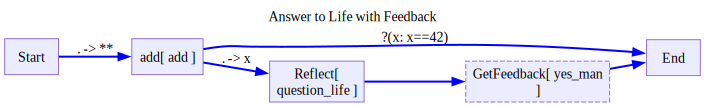

In [ ]:

with Define('Answer to Life with Feedback',type='decision') as D:
    V('add',add,
        inputs=['Start(**)'],
        outputs=[
            ('End',is_42),
            'Reflect(x=.)'
        ])
    V('Reflect',question_life,outputs=['GetFeedback'])
    # we mark a node as a breakpoint via the is_break flag
    V('GetFeedback',yes_man,is_break=True,
        outputs=['End']
    )    

D.draw()

When we run a diagram, we actually run it either to the End, or the first breakpoint we encounter.
We can check this via the `finished` attribute of the diagram.

In [ ]:
d1=D()
for trace in d1.run({'a':20,'b':22}):
    trace.pprint(skip_passthrough=True)

d1.finished,d1.output

Node add:
{'input': {'a': 20, 'b': 22}, 'output': 42}


(True, 42)

In [ ]:
d2=D()
for trace in d2.run({'a':20,'b':21}):
    trace.pprint(skip_passthrough=True)

d2.finished,d2.output

Node add:
{'input': {'a': 20, 'b': 21}, 'output': 41}
Node Reflect:
{'input': {'x': 41}, 'output': 'is 41 really the answer?'}


(False, 'is 41 really the answer?')

running an unfinished diagram again will cause it to continue, while running a finished diagram again will cause it to restart.

> Note: a finished diagram will retain state from previous runs. To get a new clean diagram instance, call the Schema again.

In [ ]:
for trace in d2.run('43 is fine too'):
    trace.pprint(skip_passthrough=True)

d2.finished,d2.output

Node GetFeedback:
{'input': {0: '43 is fine too'}, 'output': 'Yes man, 43 is fine too'}


(True, 'Yes man, 43 is fine too')

In [ ]:
for trace in d1.run({'a':7,'b':35}):
    trace.pprint(skip_passthrough=True)

d1.finished,d1.output

Node add:
{'input': {'a': 7, 'b': 35}, 'output': 42}


(True, 42)

We can use this pattern to communicate with the user in a stateful way.

Lets define a mock client, in practice, this will be your app's logic

In [ ]:
class Client:
    def __init__(self,user_messages):
        self.msg_queue = user_messages
    def end_of_conversation(self):
        return len(self.msg_queue)==0
    def get_next_user_input(self):
        next_msg = self.msg_queue.pop(0)
        print(f'User: {next_msg}')
        return next_msg
    def send_answer(self,answer):
        print(f'Assistant: {answer}')
    def new_topic(self):
        print('='*100)


        

In [ ]:
user_messages = [
    {'a':20,'b':22},
    {'a':20,'b':23},
    f'43 is fine too',
    {'a':7,'b':35}
]
client = Client(user_messages)

d=D()
while not client.end_of_conversation():
    next_input = client.get_next_user_input()
    for trace in d.run(next_input):
        pass
    client.send_answer(d.output)
    if d.finished:
        client.new_topic()

User: {'a': 20, 'b': 22}
Assistant: 42
User: {'a': 20, 'b': 23}
Assistant: is 43 really the answer?
User: 43 is fine too
Assistant: Yes man, 43 is fine too
User: {'a': 7, 'b': 35}
Assistant: 42


## Example - collecting user info

In the following example we are trying to collect information about the user.
However, since the user might not give us all the information in one go, we will want to ask followup questions until we have collected all the information.

Our agent will have two main steps:

* A chat that takes user input and parses the relvant information from it.
* A chat that sees what items are missing and phrases that as a request for the user.

Imagine we have the following user struct

In [ ]:
from pydantic import BaseModel,Field
from typing import Optional

In [ ]:
class User(BaseModel):
    name: Optional[str] = Field(None, description='The name of the user')
    age: Optional[int] = Field(None, description='The age of the user')
    email: Optional[str] = Field(None, description='The email of the user')


In [ ]:
ask_missing_data = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant asks the user for missing information.
        Do not ask for keys if they are not a part of the missing keys
        Ask the user for the following missing keys:
        {{missing_keys}}
        '''}])

format_new_info = Chat(
    model='gpt-4o-mini',
    messages=[
        {'role':'system','content':'''
        You are a helpful assistant that gets user data and makes sure it is complete.
        If you are not sure that you were given the relevant information, put None in the relevant field.
        Fill part of the missing keys based on the user data.
        If the user didnt provide info an a given missing key, leave it empty
        
        {% if current_info %}
        The information we have so far is:
        {{current_info}}
        {% endif %}
        The missing keys are:
        {{missing_keys}}
        '''},
        {'role':'user','content':'{{input}}'},
        
    ],
    output_schema=User)

Let make a function that keeps track of which keys are missing out of a pre-specified subset

In [ ]:
class MissingKeys():
    def __init__(self,keys):
        self.keys = keys

    def get_missing_keys(self,obj):
        return [key for key in self.keys if getattr(obj,key,None) is None]

    def has_missing_keys(self,obj):
        return len(self.get_missing_keys(obj)) > 0

missing = MissingKeys(['name','age'])

In [ ]:
missing.get_missing_keys(User(name='brian'))

['age']

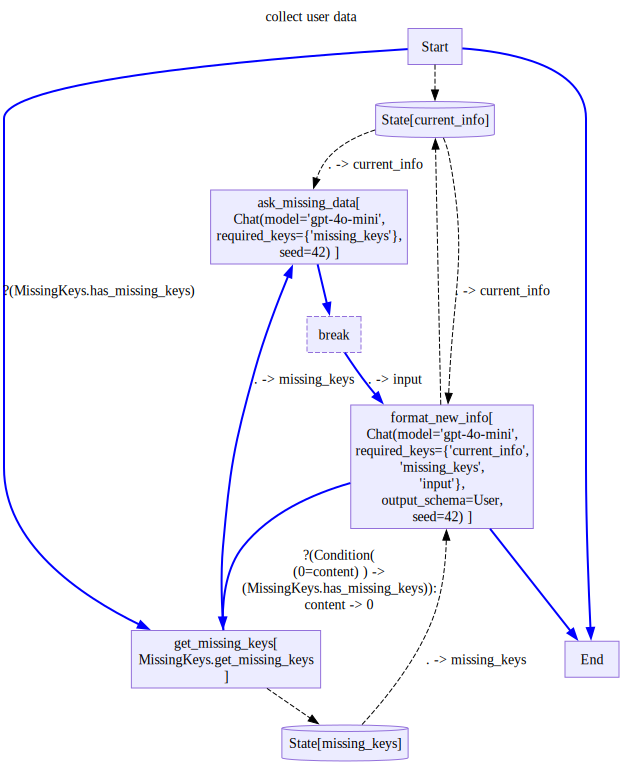

In [ ]:
with Define('collect user data',type='decision') as UserQA:
    V('Start',
        outputs=[
            ('get_missing_keys',missing.has_missing_keys),
            ('End',),
            ('state/current_info',)
        ])

    V('get_missing_keys',missing.get_missing_keys,
        outputs=[
            'ask_missing_data(missing_keys)',
            'state/missing_keys'

        ])

    V('ask_missing_data',ask_missing_data,
        inputs=['state/current_info(current_info)'],
        outputs=['break']    )

    V('break',is_break=True,outputs=['format_new_info(input)'])

    
    V('format_new_info',format_new_info,
        inputs=[
            'state/current_info(current_info)',
            'state/missing_keys(missing_keys=.)'
        ],
        outputs=[
            ('get_missing_keys(0=content)',Condition(missing.has_missing_keys,'(0=content)')),
            'End',
            'state/current_info'
        ])

UserQA.draw(direction='TB')


In [ ]:
d = UserQA()

for trace in d.run(None):
    trace.pprint()
d.output

Node Start:
{'input': {0: None}, 'output': None}
Node get_missing_keys:
{'input': {0: None}, 'output': ['name', 'age']}
Node ask_missing_data:
{ 'input': {'current_info': None, 'missing_keys': ['name', 'age']},
  'output': { 'content': 'Please provide your name and age.',
              'meta': {'input_tokens': 151, 'output_tokens': 11},
              'role': 'assistant'}}


{'role': 'assistant',
 'content': 'Please provide your name and age.',
 'meta': {'input_tokens': 151, 'output_tokens': 11}}

In [ ]:
for trace in d.run('my name is brian'):
    trace.pprint()
d.output

Node break:
{'input': {0: 'my name is brian'}, 'output': 'my name is brian'}
Node format_new_info:
{ 'input': { 'current_info': None,
             'input': 'my name is brian',
             'missing_keys': ['name', 'age']},
  'output': { 'content': User(name='brian', age=None, email=None),
              'meta': {'input_tokens': 342, 'output_tokens': 22},
              'role': 'assistant'}}
Node get_missing_keys:
{'input': {0: User(name='brian', age=None, email=None)}, 'output': ['age']}
Node ask_missing_data:
{ 'input': { 'current_info': { 'content': User(name='brian', age=None, email=None),
                               'meta': { 'input_tokens': 342,
                                         'output_tokens': 22},
                               'role': 'assistant'},
             'missing_keys': ['age']},
  'output': { 'content': 'Please provide your age.',
              'meta': {'input_tokens': 148, 'output_tokens': 9},
              'role': 'assistant'}}


{'role': 'assistant',
 'content': 'Please provide your age.',
 'meta': {'input_tokens': 148, 'output_tokens': 9}}

In [ ]:
for trace in d.run('25 yo'):
    trace.pprint()
d.output

Node break:
{'input': {0: '25 yo'}, 'output': '25 yo'}
Node format_new_info:
{ 'input': { 'current_info': { 'content': User(name='brian', age=None, email=None),
                               'meta': { 'input_tokens': 342,
                                         'output_tokens': 22},
                               'role': 'assistant'},
             'input': '25 yo',
             'missing_keys': ['age']},
  'output': { 'content': User(name='brian', age=25, email=None),
              'meta': {'input_tokens': 383, 'output_tokens': 23},
              'role': 'assistant'}}
Node End:
{ 'input': { 0: { 'content': User(name='brian', age=25, email=None),
                  'meta': {'input_tokens': 383, 'output_tokens': 23},
                  'role': 'assistant'}},
  'output': { 'content': User(name='brian', age=25, email=None),
              'meta': {'input_tokens': 383, 'output_tokens': 23},
              'role': 'assistant'}}


{'role': 'assistant',
 'content': User(name='brian', age=25, email=None),
 'meta': {'input_tokens': 383, 'output_tokens': 23}}